In [1]:
import sys
import os

from os import listdir
from os.path import isfile, join
from pathlib import Path

root = Path(os.getcwd()).parent.parent
sys.path.append(str(root))

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

### 데이터 원본

In [3]:
status_path = join(root, 'data', 'extracted', 'Korea_Covid_Patient.csv')
status = pd.read_csv(status_path)
status.head()

,District,State,data_date,new_pat,pop,long,lat,no_pat
0,Seoul,Seoul,20200122,0,9689159,126.978,37.5665,0
1,Seoul,Seoul,20200123,0,9689159,126.978,37.5665,0
2,Seoul,Seoul,20200124,1,9689159,126.978,37.5665,1
3,Seoul,Seoul,20200125,0,9689159,126.978,37.5665,1
4,Seoul,Seoul,20200126,0,9689159,126.978,37.5665,1


In [4]:
route_path = join(root, 'data', 'extracted', 'merged_route_final.csv')
route = pd.read_csv(route_path)
route['date'] = pd.to_datetime(route['date'])
route.head()

,patient_id,city,infection_case,date,type,latitude,longitude,row,col
0,2000000001,gangnam,overseas inflow,2020-01-22,hospital,37.524355,127.027948,196.0,169.0
1,1400000003,yongsan,etc,2020-01-23,etc,37.536606,126.977140,182.0,131.0
2,2000000001,gangnam,overseas inflow,2020-01-23,store,37.527752,127.019480,192.0,163.0
3,1000000001,jung,overseas inflow,2020-01-24,hospital,37.567241,127.005659,147.0,152.0
4,1400000003,jongno,etc,2020-01-24,etc,37.579617,126.977041,133.0,131.0


In [5]:
# type, reason column type에 맞게 수정

city_shrink_path = join(root, 'data', 'checklist', 'city_column.csv')
city_shrink_df = pd.read_csv(city_shrink_path)

type_shrink_path = join(root, 'data', 'checklist', 'type_column.csv')
type_shrink_df = pd.read_csv(type_shrink_path)

reason_shrink_path = join(root, 'data', 'checklist', 'infection_case_column.csv')
reason_shrink_df = pd.read_csv(reason_shrink_path)

for index, row in route.iterrows():
    new_city = city_shrink_df.loc[city_shrink_df['city'] == row['city']].iloc[0]['administrative_district']
    route.loc[index, 'city'] = new_city
    
    new_type = type_shrink_df.loc[type_shrink_df['type'] == row['type']].iloc[0]['type_1']
    route.loc[index, 'type'] = new_type
    
    new_reason = reason_shrink_df.loc[reason_shrink_df['infection_case'] == row['infection_case']].iloc[0]['infection_case_1']
    route.loc[index, 'infection_case'] = new_reason
    
route.head()

,patient_id,city,infection_case,date,type,latitude,longitude,row,col
0,2000000001,southeast,overseas,2020-01-22,medical_institution,37.524355,127.027948,196.0,169.0
1,1400000003,downtown,other,2020-01-23,other,37.536606,126.977140,182.0,131.0
2,2000000001,southeast,overseas,2020-01-23,store,37.527752,127.019480,192.0,163.0
3,1000000001,downtown,overseas,2020-01-24,medical_institution,37.567241,127.005659,147.0,152.0
4,1400000003,downtown,other,2020-01-24,other,37.579617,126.977041,133.0,131.0


### 상관 관계

In [6]:
def get_feature_count(route, status, feature_name):
    features = list(dict.fromkeys(route[feature_name].tolist()))
    features.insert(0, 'date')
    
    feature_df = pd.DataFrame(columns=features)
    for index1, day_status in status.iterrows():
        date = datetime.strptime(str(day_status['data_date']), '%Y%m%d')
        feature_df = feature_df.append({'date': date}, ignore_index=True)
        feature_df = feature_df.fillna(0)
        
        rows = route.loc[route['date'] == date]
        for index2, row in rows.iterrows():
            feature_index = feature_df.loc[feature_df['date'] == date].index[0]
            feature_df.loc[feature_index, row[feature_name]] += 1
            
    return feature_df

def save_count_df(corr_df, feature_name):
    path = join(root, 'data', 'checklist', '%s_cnt.csv' % feature_name)
    corr_df.to_csv(path, encoding='utf-8-sig', index=False)

def get_correlation(count_df, status):
    count_df = count_df.set_index(['date'])
    count_df.insert (0, 'new_patients', 0)

    for index, row in count_df.iterrows():
        str_date = index.strftime('%Y%m%d')
        row['new_patients'] = status.loc[status['data_date'] == int(str_date)].iloc[0]['new_pat']
        
    return count_df

def get_top_corr_features(corr_df):
    sorted_types = corr_df.corr().iloc[:,:1].T.iloc[0].sort_values(ascending=False).to_dict()
    top_feature_dict = dict(filter(lambda elem: elem[1] > 0.1, sorted_types.items()))
    top_corr_features = list(top_feature_dict.keys())
    
    return top_corr_features

def get_correlated_feature_groups(feature_list, corr_df):
    result_dict = dict()
    
    corr_df = corr_df.drop(columns=['new_patients'])
    for feature_elem in feature_list:
        feature_column = corr_df.columns.to_list()
        feature_column.remove(feature_elem)
        feature_column.insert(0, feature_elem)
        corr_df = corr_df[feature_column]
        
        sorted_types = corr_df.corr().iloc[:, :1].T.iloc[0].sort_values(ascending=False).to_dict()
        new_dict = dict(filter(lambda elem: elem[1] > 0.3, sorted_types.items()))
        new_list = list(new_dict.keys())
        
        result_dict.update({feature_elem: new_list})
    
    return result_dict

### 거주지 유형 상관 관계

In [7]:
city_cnt_df = get_feature_count(route, status, 'city')
# save_count_df(city_cnt_df, 'type')
city_corr_df = get_correlation(city_cnt_df, status)
top_corr_features = get_top_corr_features(city_corr_df)

print(top_corr_features)
city_corr_df

['new_patients', 'northwest', 'northeast', 'downtown']


,new_patients,southeast,downtown,northeast,northwest,southwest,other
date,,,,,,,
2020-01-22,0,1,0,0,0,0,0
2020-01-23,0,1,1,0,0,0,0
2020-01-24,1,0,2,0,0,0,0
2020-01-25,0,2,1,2,0,0,0
2020-01-26,0,0,4,4,0,0,0
...,...,...,...,...,...,...,...
2020-09-01,94,0,0,2,3,0,0
2020-09-02,101,0,0,1,0,0,0
2020-09-03,69,0,0,0,0,0,0


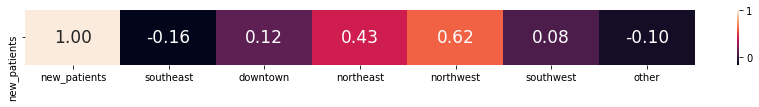

In [8]:
plt.figure(figsize=(15, 1))
sns.heatmap(city_corr_df.corr().iloc[:,:1].T, annot=True, fmt=".2f", annot_kws={"size": 17})
plt.show()

In [9]:
# 상관관계 높았던 features 위주로 element features of group 구하기
city_group_dict = get_correlated_feature_groups(top_corr_features[1:], city_corr_df)

for city in top_corr_features[1:]:
    print(city)
    print(city_group_dict[city])
    print()

northwest
['northwest', 'northeast']

northeast
['northeast', 'northwest', 'southwest', 'downtown']

downtown
['downtown', 'southwest', 'southeast', 'northeast']



### 방문지 유형 상관 관계

In [10]:
type_cnt_df = get_feature_count(route, status, 'type')
# save_count_df(type_cnt_df, 'type')
type_corr_df = get_correlation(type_cnt_df, status)
top_corr_features = get_top_corr_features(type_corr_df)

print(top_corr_features)
type_corr_df

['new_patients', 'educational_institution', 'hall', 'store', 'finantial_institution', 'sports_facility', 'service_facility', 'fnb', 'medical_institution', 'lodging', 'work', 'exhibition', 'religious_facility']


,new_patients,medical_institution,other,store,fnb,public_transportation,religious_facility,entertainment_facility,service_facility,sports_facility,...,club,public_institution,finantial_institution,gethering,outdoor,sauna,work,door_sales,exhibition,hall
date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,2,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,1,2,1,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-01,94,0,0,3,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-09-02,101,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-09-03,69,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


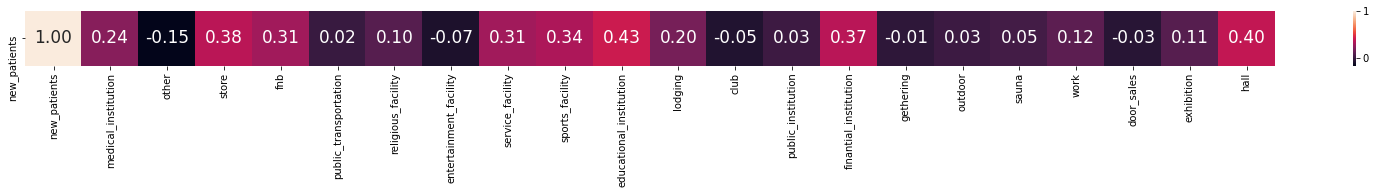

In [11]:
plt.figure(figsize=(28, 1))
sns.heatmap(type_corr_df.corr().iloc[:,:1].T, annot=True, fmt=".2f", annot_kws={"size": 17})
plt.show()

In [12]:
# 상관관계 높았던 features 위주로 element features of group 구하기
type_group_dict = get_correlated_feature_groups(top_corr_features[1:], type_corr_df)

for visit_type in top_corr_features[1:]:
    print(visit_type)
    print(type_group_dict[visit_type])
    print()

educational_institution
['educational_institution', 'finantial_institution', 'store', 'fnb']

hall
['hall', 'sports_facility', 'service_facility']

store
['store', 'fnb', 'work', 'medical_institution', 'educational_institution', 'public_transportation', 'gethering']

finantial_institution
['finantial_institution', 'educational_institution', 'service_facility', 'sports_facility', 'sauna']

sports_facility
['sports_facility', 'service_facility', 'door_sales', 'finantial_institution', 'hall', 'fnb']

service_facility
['service_facility', 'sports_facility', 'finantial_institution', 'hall', 'fnb']

fnb
['fnb', 'store', 'entertainment_facility', 'public_transportation', 'service_facility', 'club', 'sports_facility', 'educational_institution']

medical_institution
['medical_institution', 'other', 'store', 'public_transportation']

lodging
['lodging']

work
['work', 'store']

exhibition
['exhibition']

religious_facility
['religious_facility']



### 감염 원인 상관 관계

In [13]:
reason_cnt_df = get_feature_count(route, status, 'infection_case')
# save_count_df(reason_cnt_df, 'type')
reason_corr_df = get_correlation(reason_cnt_df, status)
top_corr_features = get_top_corr_features(reason_corr_df)

print(top_corr_features)
reason_corr_df

['new_patients', 'other', 'church', 'gethering', 'protest', 'contact', 'cafe', 'overseas', 'office']


,new_patients,overseas,other,contact,hospital,building,church,call_center,health_facility,educational_facility,...,network_marketing,nursing_facility,company,gethering,public_transportation,office,bank,protest,theater,cafe
date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,4,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,4,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-01,94,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-09-02,101,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-09-03,69,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


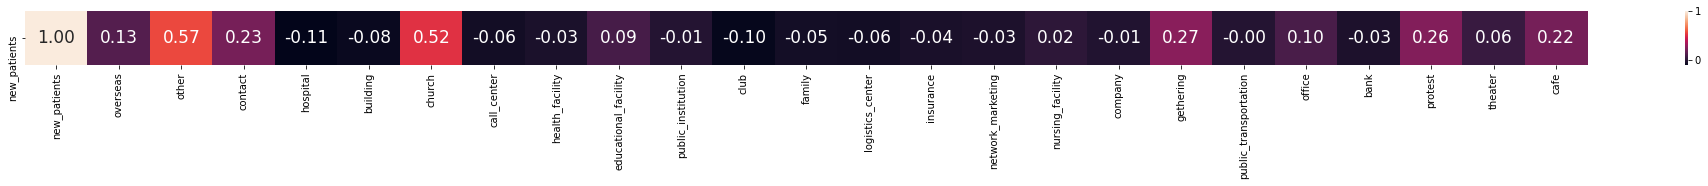

In [14]:
plt.figure(figsize=(35, 1))
sns.heatmap(reason_corr_df.corr().iloc[:,:1].T, annot=True, fmt=".2f", annot_kws={"size": 17})
plt.show()

In [15]:
# 상관관계 높았던 features 위주로 element features of group 구하기
reason_list = ['other', 'church']
reason_group_dict = get_correlated_feature_groups(top_corr_features[1:], reason_corr_df)

for reason in top_corr_features[1:]:
    print(reason)
    print(reason_group_dict[reason])
    print()

other
['other', 'church', 'contact', 'protest', 'overseas', 'theater']

church
['church', 'other', 'protest', 'contact', 'gethering']

gethering
['gethering', 'office', 'bank', 'cafe', 'church']

protest
['protest', 'church', 'other', 'theater', 'educational_facility', 'public_institution']

contact
['contact', 'other', 'call_center', 'church', 'overseas']

cafe
['cafe', 'gethering']

overseas
['overseas', 'other', 'contact']

office
['office', 'gethering', 'bank']

